In [1]:
import sys,os
__script_path=os.path.abspath(globals().get('__file__','.'))
__script_dir = os.path.dirname(__script_path)
root_dir = os.path.abspath(f'{__script_dir}/../../')
print(root_dir)
for lib in [root_dir][::-1]:
    if lib in sys.path:
        sys.path.remove(lib)
    sys.path.insert(0,lib)



e:\User\PC\ads_enefit_ueh\ads_enfit


In [2]:
from libs.common import *
from config.config import *
from models.models import VGG16

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


e:/User/PC/ads_enefit_ueh/ads_enfit


In [3]:
if os.path.exists(exps_dir) == False: # tạo thư mục (nếu chưa có)
  os.makedirs(exps_dir, exist_ok=True)

save_dir = f"{exps_dir}/exp2"
os.makedirs(save_dir, exist_ok=True)

In [4]:
plt.style.use(f'{style_dir}/style.mplstyle')
shap.initjs()

In [5]:
# wandb.init(project="enefit_prediction_consumer")


In [6]:
X_train=pd.read_csv(f'{save_dir}/X_train.csv', index_col=None)
X_valid=pd.read_csv(f'{save_dir}/X_valid.csv', index_col=None)
y_train=pd.read_csv(f'{save_dir}/y_train.csv', index_col=None)
y_valid=pd.read_csv(f'{save_dir}/y_valid.csv', index_col=None)
X_test=pd.read_csv(f'{save_dir}/X_test.csv', index_col=None)
y_test=pd.read_csv(f'{save_dir}/y_test.csv', index_col=None)


In [7]:
X_train.drop(columns=['Unnamed: 0'], inplace=True)
X_valid.drop(columns=['Unnamed: 0'], inplace=True)
y_train.drop(columns=['Unnamed: 0'], inplace=True)
y_valid.drop(columns=['Unnamed: 0'], inplace=True)
X_test.drop(columns=['Unnamed: 0'], inplace=True)
y_test.drop(columns=['Unnamed: 0'], inplace=True)
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape)

(1079454, 141) (1079454, 1) (531672, 141) (531672, 1) (6144, 141) (6144, 1)


In [8]:
def r2(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [9]:
vgg16_model = VGG16(input_shape=(X_train.shape[1],1), filter_size= 32).model
lr=0.0001
vgg16_model.compile(optimizer=Adam(learning_rate=lr), loss='mse', metrics=['mae', r2])
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 141, 1)]          0         
                                                                 
 block1_conv1 (Conv1D)       (None, 141, 32)           128       
                                                                 
 block1_conv2 (Conv1D)       (None, 141, 32)           3104      
                                                                 
 block1_pool (MaxPooling1D)  (None, 70, 32)            0         
                                                                 
 block2_conv1 (Conv1D)       (None, 70, 64)            6208      
                                                                 
 block2_conv2 (Conv1D)       (None, 70, 64)            12352     
                                                                 
 block2_pool (MaxPooling1D)  (None, 35, 64)            0     

In [10]:
early_stopping = EarlyStopping(monitor='val_loss',
                                mode='min',
    min_delta=0.00005,
    patience=2,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    mode='min',
    factor=0.5,
    patience=6,
    min_lr=0.000001,
    verbose=1,
)
checkpoint_callback = ModelCheckpoint(
    filepath='cnn.hdf5', 
    monitor='val_loss', 
    mode='min',
    save_best_only=True, 
    verbose=1,  
    save_format="tf"
)

In [11]:
vgg16_model.fit(X_train,y_train,
          validation_data=(X_valid,y_valid),
          batch_size=64,epochs= 10000, callbacks=[early_stopping,lr_scheduler,checkpoint_callback])

Epoch 1/10000
16866/16867 [============================>.] - ETA: 0s - loss: 42699.3164 - mae: 65.3399 - r2: 0.8858
Epoch 1: val_loss improved from inf to 61799.57422, saving model to cnn.hdf5
16867/16867 [==============================] - 721s 43ms/step - loss: 42698.7227 - mae: 65.3398 - r2: 0.8858 - val_loss: 61799.5742 - val_mae: 76.0871 - val_r2: 0.9236 - lr: 1.0000e-04
Epoch 2/10000
16867/16867 [==============================] - ETA: 0s - loss: 29080.8281 - mae: 55.6672 - r2: 0.9139
Epoch 2: val_loss improved from 61799.57422 to 53107.65234, saving model to cnn.hdf5
16867/16867 [==============================] - 694s 41ms/step - loss: 29080.8281 - mae: 55.6672 - r2: 0.9139 - val_loss: 53107.6523 - val_mae: 70.3391 - val_r2: 0.9372 - lr: 1.0000e-04
Epoch 3/10000
16867/16867 [==============================] - ETA: 0s - loss: 24684.8320 - mae: 51.6795 - r2: 0.9262
Epoch 3: val_loss improved from 53107.65234 to 52435.06250, saving model to cnn.hdf5
16867/16867 [======================

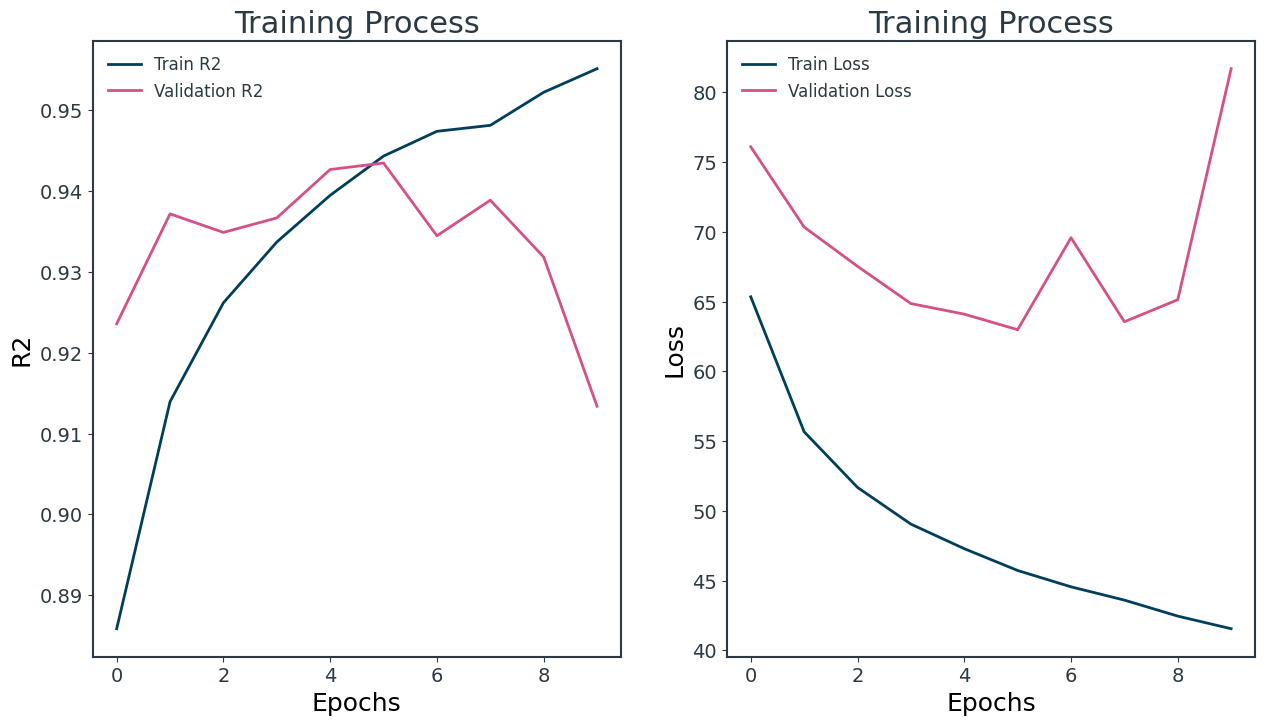

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

history = vgg16_model.history.history

fig, axes = plt.subplots(1, 2, figsize=(15, 8))

axes[0].plot(pd.DataFrame(history['r2']), label='Train R2')
axes[0].plot(pd.DataFrame(history['val_r2']), label='Validation R2')
axes[0].set_title('Training Process')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('R2')
axes[0].legend()

axes[1].plot(pd.DataFrame(history['mae']), label='Train Loss')
axes[1].plot(pd.DataFrame(history['val_mae']), label='Validation Loss')
axes[1].set_title('Training Process')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.show()


In [ ]:
# Truy cập vào lịch sử của mô hình
training_history = model.history.history

# In ra các keys của lịch sử
print(training_history.keys())

# In ra các giá trị của loss và accuracy qua các epochs
print(training_history['loss'])
print(training_history['val_loss'])

dict_keys(['loss', 'mae', 'r2', 'val_loss', 'val_mae', 'val_r2', 'lr'])
[0.27867409586906433, 0.16802802681922913, 0.16319255530834198, 0.1602688580751419, 0.15744855999946594, 0.15642601251602173, 0.1550084799528122, 0.1530928909778595, 0.1507459282875061, 0.14986762404441833, 0.14858509600162506, 0.14747820794582367, 0.146505668759346, 0.145559623837471, 0.14535941183567047, 0.14452539384365082, 0.14331842958927155, 0.14410321414470673, 0.14326080679893494, 0.14306819438934326, 0.14288999140262604, 0.14210566878318787, 0.14115774631500244, 0.14074353873729706, 0.13989345729351044, 0.1398756057024002, 0.1401626467704773, 0.13956405222415924, 0.13965880870819092, 0.13926059007644653, 0.1395166516304016]
[0.10986501723527908, 0.11377602815628052, 0.11206255853176117, 0.10958410054445267, 0.10489418357610703, 0.11137233674526215, 0.1133689284324646, 0.11217392235994339, 0.10836607962846756, 0.10959485918283463, 0.09488733857870102, 0.09816332161426544, 0.10558769851922989, 0.112541772425

In [15]:
from sklearn.metrics import r2_score, mean_absolute_error

# Dự đoán trên tập validation
y_pred = vgg16_model.predict(X_test)

# Tính toán R2 Score
r2 = r2_score(y_test, y_pred)

# Tính toán MAE
mae = mean_absolute_error(y_test, y_pred)

print(f"R2 Score: {r2}")
print(f"MAE: {mae}")


192/192 [==============================] - 2s 7ms/step
R2 Score: 0.9103344477012458
MAE: 88.16397080333427
